In [1]:
#If this is your first run, Please run voiced_database_init.py before running this file!
import warnings
warnings.filterwarnings('ignore')

In [2]:
from fastaudio.augment.all import *
from fastaudio.core.all import *
from fastai.vision.all import *
from fastaudio.ci import skip_if_ci
from fastai.callback.fp16 import *
import pandas as pd
set_seed(12)

In [3]:
df = pd.read_csv("../data/voiced/voiced_clean/dataset.csv")
df.head(10)

,filename,sex,fold,target
0,voice188.wav,0,1,pathological
1,voice033.wav,0,0,pathological
2,voice144.wav,0,0,pathological
3,voice016.wav,0,0,pathological
4,voice116.wav,0,0,pathological
5,voice129.wav,1,0,pathological
6,voice053.wav,0,1,pathological
7,voice132.wav,1,0,pathological
8,voice049.wav,0,1,healthy
9,voice059.wav,0,0,pathological


In [4]:
df.value_counts(['target', 'sex'], normalize=True)

target        sex
pathological  0      0.475962
              1      0.250000
healthy       0      0.173077
              1      0.100962
dtype: float64

In [5]:
df.value_counts(['target'], normalize=True)

target      
pathological    0.725962
healthy         0.274038
dtype: float64

In [6]:
def CrossValidationSplitter(col='fold', fold=1):
    def _inner(o):
        assert isinstance(o, pd.DataFrame), "ColSplitter only works when your items are a pandas DataFrame"
        col_values = o.iloc[:,col] if isinstance(col, int) else o[col]
        valid_idx = (col_values == fold).values.astype('bool')
        return IndexSplitter(mask2idxs(valid_idx))(o)
    return _inner

In [7]:
cfg = AudioConfig.BasicMelSpectrogram(n_fft=512)
a2s = AudioToSpec.from_cfg(cfg)

In [8]:
auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 get_x = ColReader("filename", pref="../data/voiced/voiced_clean/"), 
                 splitter = CrossValidationSplitter(fold=1),
                 item_tfms=[ResizeSignal(1500)],
                 batch_tfms = [a2s],
                 get_y = ColReader("target"))

In [9]:
dbunch = auds.dataloaders(df, bs=64, seed=12)

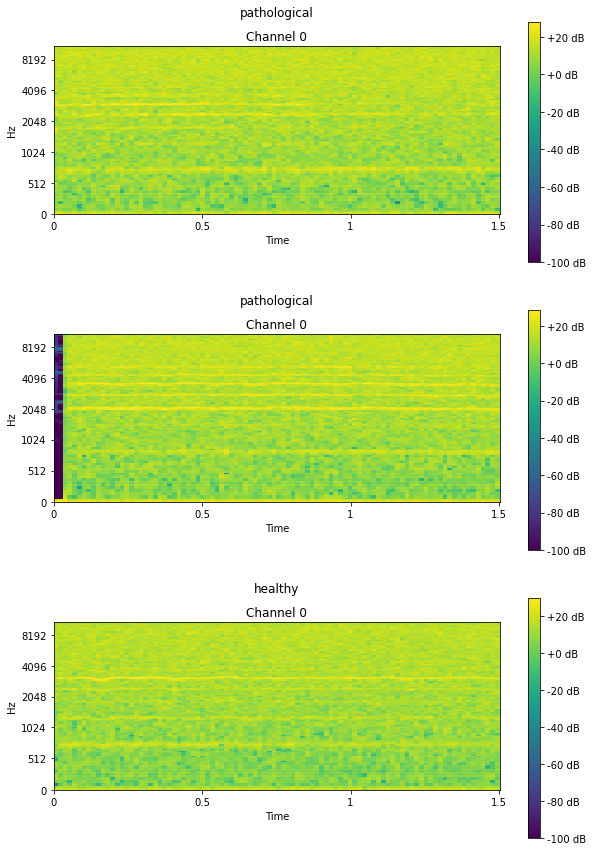

In [10]:
dbunch.valid.show_batch(nrows=3, figsize=(10, 15))

In [11]:
learn = cnn_learner(dbunch, 
            resnet18,
            n_in=1,
            loss_func=CrossEntropyLossFlat(), 
            metrics=[accuracy]).to_fp16()

In [12]:
learn.fine_tune(3, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,time
0,1.371197,1.443549,0.691589,00:01
1,1.386846,1.665390,0.691589,00:00
2,1.296041,1.279982,0.691589,00:00


epoch,train_loss,valid_loss,accuracy,time
0,1.155164,0.943847,0.691589,00:01
1,1.093342,0.719888,0.700935,00:00
2,1.104457,0.581929,0.738318,00:00
